In [113]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import math
from apyori import apriori

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.cluster import KMeans 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from boruta import BorutaPy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix,classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
df=pd.read_csv('Laundry_Data.csv')

# Data Cleaning

In [4]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   No             807 non-null    int64  
 1   Date           807 non-null    object 
 2   Time           807 non-null    object 
 3   Race           752 non-null    object 
 4   Gender         716 non-null    object 
 5   Body_Size      709 non-null    object 
 6   Age_Range      756 non-null    float64
 7   With_Kids      725 non-null    object 
 8   Kids_Category  777 non-null    object 
 9   Basket_Size    752 non-null    object 
 10  Basket_colour  717 non-null    object 
 11  Attire         776 non-null    object 
 12  Shirt_Colour   720 non-null    object 
 13  shirt_type     770 non-null    object 
 14  Pants_Colour   802 non-null    object 
 15  pants_type     712 non-null    object 
 16  Wash_Item      718 non-null    object 
 17  Washer_No      807 non-null    int64  
 18  Dryer_No  

,No,Date,Time,Race,Gender,Body_Size,Age_Range,With_Kids,Kids_Category,Basket_Size,Basket_colour,Attire,Shirt_Colour,shirt_type,Pants_Colour,pants_type,Wash_Item,Washer_No,Dryer_No,Spectacles
0,1,19/10/2015,20:17:50,malay,NaN,moderate,NaN,yes,young,big,red,casual,blue,short_sleeve,black,short,clothes,3,10,no
1,2,19/10/2015,20:28:42,indian,male,thin,32.0,no,no_kids,big,green,casual,NaN,short_sleeve,blue_jeans,long,NaN,6,9,no
2,3,19/10/2015,20:58:31,malay,female,NaN,30.0,no,no_kids,big,blue,casual,red,short_sleeve,black,long,NaN,4,10,no
3,4,19/10/2015,21:31:28,indian,male,thin,51.0,no,no_kids,NaN,black,casual,NaN,short_sleeve,yellow,short,clothes,5,9,no
4,5,19/10/2015,21:40:28,indian,male,moderate,34.0,no,no_kids,big,blue,casual,blue,short_sleeve,white,long,clothes,3,9,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,803,09/12/2015,20:05:46,malay,female,moderate,45.0,NaN,no_kids,small,white,casual,red,long sleeve,black,long,clothes,3,10,no
803,804,09/12/2015,20:33:01,malay,male,fat,34.0,no,no_kids,big,grey,casual,white,short_sleeve,black,long,blankets,3,7,no
804,805,09/12/2015,20:37:01,malay,female,moderate,53.0,no,no_kids,big,purple,traditional,pink,long sleeve,pink,long,clothes,3,7,yes
805,806,09/12/2015,20:42:57,indian,female,moderate,37.0,no,no_kids,big,green,traditional,brown,short_sleeve,black,long,clothes,6,10,no


In [132]:
def fill_null_val(df):
    return df.fillna('Unknown')

def change_to_date(df):
    date=pd.to_datetime(df['Date'], infer_datetime_format=True)
    return df.assign(Date=date)

def change_to_time(df):
    time=pd.to_datetime(df['Time'], infer_datetime_format=True)
    time=pd.DatetimeIndex(time).time
    return df.assign(Time=time)

def get_day_col(df):
    dayCol=pd.DatetimeIndex(df['Date']).day
    return df.assign(Day=dayCol)

def get_month_col(df):
    monthCol=pd.DatetimeIndex(df['Date']).month
    return df.assign(Month=monthCol)

def get_hour(df):
    hour = pd.DatetimeIndex(df['Time']).hour
    return df.assign(Hour=hour)

def get_time_of_day(df):
    timeOfDay=pd.cut(pd.DatetimeIndex(df['Time']).hour, bins=[-1,4,11,15,19,23], labels=["Midnight","Morning", "Afternoon", "Evening","Night"]).astype(str)
    return df.assign(Time_Of_Day=timeOfDay)

def fill_age(df):
    age=df['Age_Range'].fillna(round(df['Age_Range'].mean()))
    age=age.astype('int64') 
    return df.assign(Age_Range=age)

def fill_withKids_yes(df):
    with_kids = np.where(df["Kids_Category"]=='no_kids',df['With_Kids'],'yes')
    return df.assign(With_Kids=with_kids)

def drop_no(df):
    return df.drop('No',axis=1)

def fill_withKids_no(df):
    with_kids = np.where(df["Kids_Category"]!='no_kids',df['With_Kids'],'no')
    return df.assign(With_Kids=with_kids)

def W6_big(df):
    washer = np.where(df["Washer_No"]!=6,df['Basket_Size'],'big')
    return df.assign(Basket_Size=washer)

def bin_age(df):
    age_group= pd.cut(x=df['Age_Range'], bins=[20, 30, 40, 50,60]).astype(str)
    return df.assign(Age_Group=age_group)

def mark_washer(df):
    washer = df['Washer_No'].apply(lambda x: "{}{}".format('W_', x))
    return df.assign(Washer_No=washer)

def mark_dryer(df):
    dryer = df['Dryer_No'].apply(lambda x: "{}{}".format('D_', x))
    return df.assign(Dryer_No=dryer)

def mark_shirt(df):
    shirt = df['shirt_type'].apply(lambda x: "{}{}".format('S_', x))
    return df.assign(shirt_type=shirt)

def mark_pants(df):
    pants = df['pants_type'].apply(lambda x: "{}{}".format('P_', x))
    return df.assign(pants_type=pants)

arm_drop=['Date','Time','Age_Range','Race','Gender','Body_Size','With_Kids','Kids_Category','Spectacles']


cluster_select=['Time_Of_Day','Hour','Race','Gender','Age_Group','Age_Range','Body_Size','With_Kids','Kids_Category','Basket_Size']


def drop_arm(df):
    return df.drop(columns=arm_drop)

def drop_BORUTA(df):
    df1=df.copy()
    return df.drop(columns=['Date','Time','Day','Month'])

def select_arm2(df):
    return df[arm_select2]

arm_select2=['Time_Of_Day','Gender','Body_Size','Age_Group','Attire','Kids_Category','Spectacles']

def select_cluster(df):
    return df[cluster_select]

def select_classifier1(df):
    return df[classifier1_select]

In [130]:
cleaned=(df.pipe(change_to_date)
        .pipe(get_day_col)
        .pipe(get_month_col)
        .pipe(get_hour)
        .pipe(fill_age)
        .pipe(fill_withKids_yes)
        .pipe(fill_withKids_no)
        .pipe(mark_washer)
        .pipe(mark_dryer)
        .pipe(drop_no)
        .pipe(fill_null_val)
        .pipe(get_time_of_day)
        .pipe(bin_age)
    )

# Exploratory Data Analysis

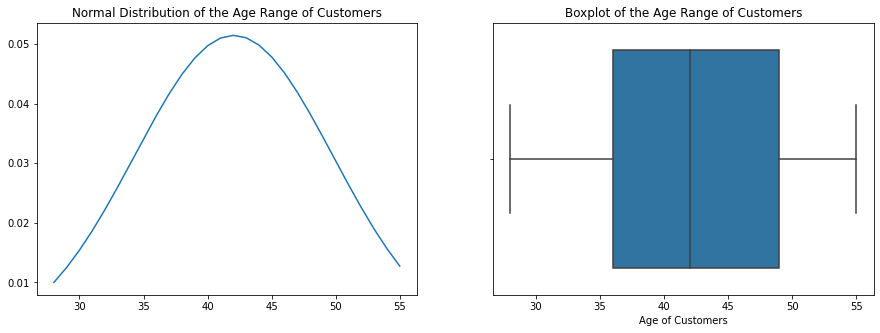

Min:  28
Mean:  42.04089219330855
Max:  55
Standard Deviation:  7.753453925764963


In [43]:
h = cleaned['Age_Range'].tolist()
h.sort()

hmin=np.min(h)
hmean = np.mean(h)
hmax = np.max(h)
hstd = np.std(h)

pdf = stats.norm.pdf(h, hmean, hstd)

plt.figure(figsize=(15,5))
plt.subplot(121),plt.plot(h, pdf),plt.title('Normal Distribution of the Age Range of Customers')
plt.subplot(122),sns.boxplot(cleaned['Age_Range']),plt.title('Boxplot of the Age Range of Customers'),plt.xlabel('Age of Customers')
plt.show()

print('Min: ',hmin)
print('Mean: ',hmean)
print('Max: ',hmax)
print('Standard Deviation: ',hstd)

Text(0, 0.5, 'Number of Customers')

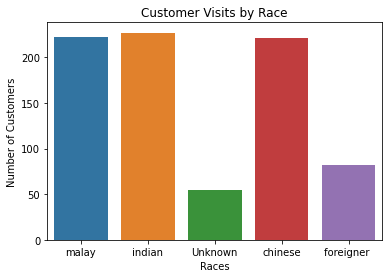

In [46]:
ax=sns.countplot(data = cleaned, x = 'Race')
plt.title ('Customer Visits by Race')
plt.xlabel('Races')
plt.ylabel('Number of Customers')

Text(0, 0.5, 'Presence of Kids')

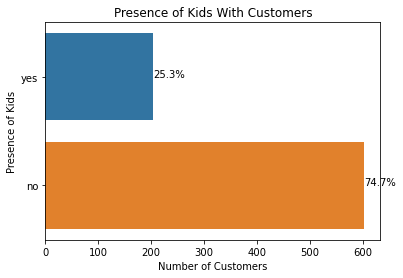

In [44]:
ax=sns.countplot(data = cleaned, y = 'With_Kids')
total = len(df['With_Kids'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.title ('Presence of Kids With Customers')
plt.xlabel('Number of Customers')
plt.ylabel('Presence of Kids')

Text(0, 0.5, 'Number of Customers')

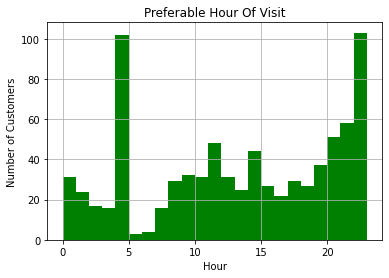

In [47]:
hours=pd.to_datetime(df['Time']).dt.hour
hours.hist(bins = 23, range=[0,23], facecolor='green')
plt.title ('Preferable Hour Of Visit')
plt.xlabel('Hour')
plt.ylabel('Number of Customers')

# Applying ARM

### First Group of columns (Washing Related)

In [122]:
def select_arm1(df):
    return df[arm_select1]

arm_select1=['Time_Of_Day','Basket_Size','Basket_colour','Washer_No','Dryer_No','Wash_Item']

In [123]:
arm1=(cleaned.pipe(select_arm1))
arm1

,Time_Of_Day,Basket_Size,Basket_colour,Washer_No,Dryer_No,Wash_Item
0,Night,big,red,W_3,D_10,clothes
1,Night,big,green,W_6,D_9,Unknown
2,Night,big,blue,W_4,D_10,Unknown
3,Night,Unknown,black,W_5,D_9,clothes
4,Night,big,blue,W_3,D_9,clothes
...,...,...,...,...,...,...
802,Night,small,white,W_3,D_10,clothes
803,Night,big,grey,W_3,D_7,blankets
804,Night,big,purple,W_3,D_7,clothes
805,Night,big,green,W_6,D_10,clothes


In [50]:
records = []

# Iterate over each row 
for index, rows in arm1.iterrows(): 
    columns=arm1.columns
    my_list =[] 
    for att in columns:
        my_list.append(str(rows[att]))
      
    # append the list to the final list 
    records.append(my_list)
    
records

[['Night', 'big', 'red', 'W_3', 'D_10', 'clothes'],
 ['Night', 'big', 'green', 'W_6', 'D_9', 'Unknown'],
 ['Night', 'big', 'blue', 'W_4', 'D_10', 'Unknown'],
 ['Night', 'Unknown', 'black', 'W_5', 'D_9', 'clothes'],
 ['Night', 'big', 'blue', 'W_3', 'D_9', 'clothes'],
 ['Night', 'small', 'white', 'W_4', 'D_8', 'clothes'],
 ['Night', 'big', 'pink', 'W_5', 'D_10', 'clothes'],
 ['Midnight', 'big', 'blue', 'W_3', 'D_9', 'clothes'],
 ['Midnight', 'small', 'purple', 'W_6', 'D_10', 'clothes'],
 ['Midnight', 'small', 'pink', 'W_5', 'D_7', 'Unknown'],
 ['Midnight', 'big', 'red', 'W_4', 'D_8', 'Unknown'],
 ['Morning', 'Unknown', 'blue', 'W_4', 'D_8', 'Unknown'],
 ['Morning', 'big', 'blue', 'W_3', 'D_7', 'clothes'],
 ['Morning', 'big', 'yellow', 'W_3', 'D_9', 'clothes'],
 ['Morning', 'big', 'red', 'W_3', 'D_8', 'clothes'],
 ['Morning', 'big', 'brown', 'W_5', 'D_9', 'clothes'],
 ['Morning', 'Unknown', 'Unknown', 'W_4', 'D_7', 'clothes'],
 ['Morning', 'big', 'blue', 'W_5', 'D_9', 'clothes'],
 ['Morni

In [51]:
association_rules = apriori(records, min_support=0.02, min_confidence=0.6, min_lift=2, min_length=2)
association_results = list(association_rules)
len(association_results)

6

In [110]:
cnt =0

for item in association_results:
    cnt += 1
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("(Rule " + str(cnt) + ") " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(round(item[1],3)))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(round(item[2][0][2],4)))
    print("Lift: " + str(round(item[2][0][3],4)))
    print("=====================================")

(Rule 1) D_7 -> blankets
Support: 0.021
Confidence: 0.6071
Lift: 2.1029
(Rule 2) D_7 -> W_3
Support: 0.037
Confidence: 0.6522
Lift: 2.2588
(Rule 3) clothes -> blue
Support: 0.021
Confidence: 0.68
Lift: 2.8142
(Rule 4) D_7 -> W_3
Support: 0.033
Confidence: 0.6279
Lift: 2.1748
(Rule 5) D_7 -> blue
Support: 0.03
Confidence: 0.6
Lift: 2.1237
(Rule 6) blue -> D_10
Support: 0.021
Confidence: 0.68
Lift: 3.286


### First Group of columns (Customer Related)

In [120]:
arm_select2=['Time_Of_Day','Gender','Body_Size','Age_Group','Attire','Kids_Category','Spectacles']

def select_arm2(df):
    return df[arm_select2]

In [52]:
arm2=(cleaned.pipe(select_arm2))
arm2

In [54]:
records2 = []

# Iterate over each row 
for index, rows in arm2.iterrows(): 
    columns=arm2.columns
    my_list =[] 
    for att in columns:
        my_list.append(str(rows[att]))
      
    # append the list to the final list 
    records2.append(my_list)
    
records2

[['Night', 'Unknown', 'moderate', '(40, 50]', 'casual', 'young', 'no'],
 ['Night', 'male', 'thin', '(30, 40]', 'casual', 'no_kids', 'no'],
 ['Night', 'female', 'Unknown', '(20, 30]', 'casual', 'no_kids', 'no'],
 ['Night', 'male', 'thin', '(50, 60]', 'casual', 'no_kids', 'no'],
 ['Night', 'male', 'moderate', '(30, 40]', 'casual', 'no_kids', 'no'],
 ['Night', 'male', 'fat', '(40, 50]', 'casual', 'no_kids', 'no'],
 ['Night', 'female', 'fat', '(40, 50]', 'traditional', 'no_kids', 'no'],
 ['Midnight', 'male', 'thin', '(40, 50]', 'casual', 'Unknown', 'no'],
 ['Midnight', 'male', 'thin', '(20, 30]', 'casual', 'no_kids', 'no'],
 ['Midnight', 'male', 'moderate', '(30, 40]', 'casual', 'no_kids', 'no'],
 ['Midnight', 'female', 'Unknown', '(40, 50]', 'Unknown', 'no_kids', 'no'],
 ['Morning', 'male', 'moderate', '(30, 40]', 'casual', 'no_kids', 'no'],
 ['Morning', 'female', 'moderate', '(40, 50]', 'casual', 'no_kids', 'no'],
 ['Morning', 'male', 'moderate', '(40, 50]', 'casual', 'no_kids', 'yes'],


In [55]:
association_rules = apriori(records2, min_support=0.015, min_confidence=0.6, min_lift=2, min_length=2)
association_results = list(association_rules)
len(association_results)

23

In [56]:
cnt =0

for item in association_results:
    cnt += 1
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("(Rule " + str(cnt) + ") " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(round(item[1],3)))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(round(item[2][0][2],4)))
    print("Lift: " + str(round(item[2][0][3],4)))
    print("=====================================")

(Rule 1) female -> (40, 50]
Support: 0.025
Confidence: 0.9524
Lift: 2.129
(Rule 2) Midnight -> baby
Support: 0.022
Confidence: 0.9
Lift: 2.0119
(Rule 3) Midnight -> formal
Support: 0.019
Confidence: 0.75
Lift: 5.9926
(Rule 4) no -> Midnight
Support: 0.022
Confidence: 0.6
Lift: 2.5484
(Rule 5) no -> traditional
Support: 0.035
Confidence: 0.6512
Lift: 2.1275
(Rule 6) Midnight -> formal
Support: 0.019
Confidence: 0.625
Lift: 2.6546
(Rule 7) no -> female
Support: 0.019
Confidence: 0.9375
Lift: 2.0957
(Rule 8) female -> (40, 50]
Support: 0.02
Confidence: 0.7619
Lift: 2.5943
(Rule 9) female -> traditional
Support: 0.017
Confidence: 0.8235
Lift: 2.8042
(Rule 10) Midnight -> formal
Support: 0.017
Confidence: 0.7
Lift: 12.8386
(Rule 11) no -> Midnight
Support: 0.02
Confidence: 0.8
Lift: 2.1167
(Rule 12) no -> Midnight
Support: 0.016
Confidence: 0.65
Lift: 6.397
(Rule 13) Midnight -> formal
Support: 0.016
Confidence: 0.619
Lift: 2.6293
(Rule 14) male -> Midnight
Support: 0.02
Confidence: 0.8889


# Clustering

In [135]:
cluster=(cleaned.pipe(select_cluster))
cluster.info()
cluster

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Time_Of_Day    807 non-null    object
 1   Hour           807 non-null    int64 
 2   Race           807 non-null    object
 3   Gender         807 non-null    object
 4   Age_Group      807 non-null    object
 5   Age_Range      807 non-null    int64 
 6   Body_Size      807 non-null    object
 7   With_Kids      807 non-null    object
 8   Kids_Category  807 non-null    object
 9   Basket_Size    807 non-null    object
dtypes: int64(2), object(8)
memory usage: 63.2+ KB


,Time_Of_Day,Hour,Race,Gender,Age_Group,Age_Range,Body_Size,With_Kids,Kids_Category,Basket_Size
0,Night,20,malay,Unknown,"(40, 50]",42,moderate,yes,young,big
1,Night,20,indian,male,"(30, 40]",32,thin,no,no_kids,big
2,Night,20,malay,female,"(20, 30]",30,Unknown,no,no_kids,big
3,Night,21,indian,male,"(50, 60]",51,thin,no,no_kids,Unknown
4,Night,21,indian,male,"(30, 40]",34,moderate,no,no_kids,big
...,...,...,...,...,...,...,...,...,...,...
802,Night,20,malay,female,"(40, 50]",45,moderate,no,no_kids,small
803,Night,20,malay,male,"(30, 40]",34,fat,no,no_kids,big
804,Night,20,malay,female,"(50, 60]",53,moderate,no,no_kids,big
805,Night,20,indian,female,"(30, 40]",37,moderate,no,no_kids,big


In [136]:
cluster_dum=pd.get_dummies(cluster,drop_first=True)
cluster_dum

,Hour,Age_Range,Time_Of_Day_Evening,Time_Of_Day_Midnight,Time_Of_Day_Morning,Time_Of_Day_Night,Race_chinese,Race_foreigner,Race_indian,Race_malay,...,Body_Size_moderate,Body_Size_thin,With_Kids_yes,Kids_Category_baby,Kids_Category_no_kids,Kids_Category_toddler,Kids_Category_toddler,Kids_Category_young,Basket_Size_big,Basket_Size_small
0,20,42,0,0,0,1,0,0,0,1,...,1,0,1,0,0,0,0,1,1,0
1,20,32,0,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
2,20,30,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,21,51,0,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
4,21,34,0,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,20,45,0,0,0,1,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1
803,20,34,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
804,20,53,0,0,0,1,0,0,0,1,...,1,0,0,0,1,0,0,0,1,0
805,20,37,0,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0


### Elbow analysis

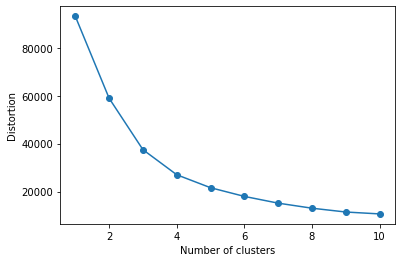

In [137]:
distortions = []

# your codes here...
for i in range(1,11):
    km=KMeans(
        n_clusters=i,
        init='random',
        n_init=10,
        max_iter=300,
        tol=1e-4,
        random_state=0
    )
    km.fit(cluster_dum)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

##conclusion, use k=2/3(elbow)

In [141]:
km=KMeans(n_clusters=3,random_state=1)
km.fit(cluster_dum)

cluster_vis=cluster.copy()
cluster_vis['label']=km.labels_

cluster_vis

,Time_Of_Day,Hour,Race,Gender,Age_Group,Age_Range,Body_Size,With_Kids,Kids_Category,Basket_Size,label
0,Night,20,malay,Unknown,"(40, 50]",42,moderate,yes,young,big,1
1,Night,20,indian,male,"(30, 40]",32,thin,no,no_kids,big,1
2,Night,20,malay,female,"(20, 30]",30,Unknown,no,no_kids,big,1
3,Night,21,indian,male,"(50, 60]",51,thin,no,no_kids,Unknown,0
4,Night,21,indian,male,"(30, 40]",34,moderate,no,no_kids,big,1
...,...,...,...,...,...,...,...,...,...,...,...
802,Night,20,malay,female,"(40, 50]",45,moderate,no,no_kids,small,1
803,Night,20,malay,male,"(30, 40]",34,fat,no,no_kids,big,1
804,Night,20,malay,female,"(50, 60]",53,moderate,no,no_kids,big,0
805,Night,20,indian,female,"(30, 40]",37,moderate,no,no_kids,big,1


Text(0.5, 1.0, 'Ages of Clusters')

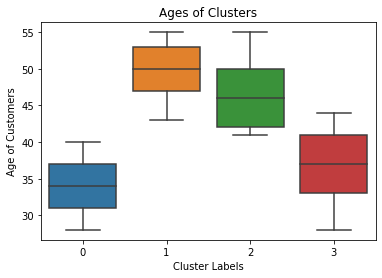

In [139]:
#ax = sns.relplot(x="Age_Range", y="Time_Of_Day", hue=cluster_vis.label.tolist(), data=cluster_vis)
sns.boxplot(x="label", y="Age_Range", data=cluster_vis)
plt.xlabel('Cluster Labels')
plt.ylabel('Age of Customers')
plt.title('Ages of Clusters')

Text(0.5, 1.0, 'Hours Visited by Clusters')

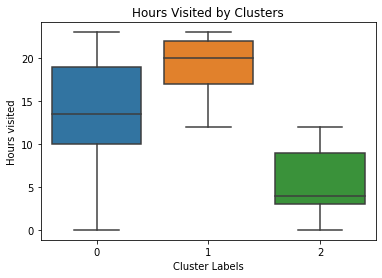

In [142]:
sns.boxplot(x="label", y="Hour", data=cluster_vis)
plt.xlabel('Cluster Labels')
plt.ylabel('Hours visited')
plt.title('Hours Visited by Clusters')

# Classification

In [63]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

### Classification 1 (Basket Size)

Applying BORUTA Feature Selection

In [94]:
c1=(cleaned.pipe(drop_BORUTA))

In [95]:
c1_boruto=c1.apply(LabelEncoder().fit_transform)

y = c1_boruto.Basket_Size
X = c1_boruto.drop("Basket_Size", 1)
colnames = X.columns

In [96]:
rf = RandomForestClassifier(n_jobs=-1,class_weight="balanced",max_depth=5)
feat_selector = BorutaPy(rf, n_estimators="auto",random_state =1)

feat_selector.fit(X.values,y.values.ravel())

boruta_score = ranking(list(map(float, feat_selector.ranking_)), colnames, order=-1)
boruta_score = pd.DataFrame(list(boruta_score.items()), columns=['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score",ascending=False)

In [97]:
# your codes here...
print('---------Top 10----------')
display(boruta_score.head(10))

# your codes here...
print('---------Bottom 10----------')
boruta_score.tail(10)

---------Top 10----------


,Features,Score
6,Basket_colour,1.00
0,Race,0.94
3,Age_Range,0.88
7,Attire,0.82
10,Pants_Colour,0.76
8,Shirt_Colour,0.71
13,Washer_No,0.71
16,Time_Of_Day,0.59
14,Dryer_No,0.53
2,Body_Size,0.47


---------Bottom 10----------


,Features,Score
14,Dryer_No,0.53
2,Body_Size,0.47
5,Kids_Category,0.35
1,Gender,0.35
12,Wash_Item,0.35
11,pants_type,0.24
17,Age_Group,0.18
9,shirt_type,0.12
15,Spectacles,0.06
4,With_Kids,0.00


Using Suggested Features on SVM Classifier

In [98]:
X=c1_boruto[['Basket_colour','Race','Age_Range','Attire','Pants_Colour','Shirt_Colour','Washer_No','Time_Of_Day','Dryer_No','Body_Size']]
y=cleaned['Basket_Size']

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [100]:
clf = SVC(kernel='linear',gamma='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [101]:
confusion_majority=confusion_matrix(y_test, y_pred)
print("Accuracy on test set: {:.3f}".format(clf.score(X_test, y_test)))
print("Precision= {:.2f}".format(precision_score(y_test,y_pred, average='micro')))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred, average='micro')))

mcm=multilabel_confusion_matrix(y_test, y_pred,labels=["big", "small", "Unknown"])
print(mcm)

Accuracy on test set: 0.852
Precision= 0.85
Recall= 0.85
[[[  0  24]
  [  0 138]]

 [[150   0]
  [ 12   0]]

 [[150   0]
  [ 12   0]]]


### Classification 2 (With Kids)

Applying BORUTA Feature Selection

In [105]:
c2=(cleaned.pipe(drop_BORUTA))
c2_boruta=c2.apply(LabelEncoder().fit_transform)

y = c2_boruta.With_Kids
X = c2_boruta.drop("With_Kids", 1)
colnames = X.columns

In [106]:
rf = RandomForestClassifier(n_jobs=-1,class_weight="balanced",max_depth=5)
feat_selector = BorutaPy(rf, n_estimators="auto",random_state =1)

feat_selector.fit(X.values,y.values.ravel())

boruta_score = ranking(list(map(float, feat_selector.ranking_)), colnames, order=-1)
boruta_score = pd.DataFrame(list(boruta_score.items()), columns=['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score",ascending=False)

In [107]:
# your codes here...
print('---------Top 10----------')
display(boruta_score.head(10))

# your codes here...
print('---------Bottom 10----------')
boruta_score.tail(10)

---------Top 10----------


,Features,Score
4,Kids_Category,1.00
8,Shirt_Colour,1.00
1,Gender,1.00
10,Pants_Colour,1.00
3,Age_Range,0.93
12,Wash_Item,0.86
0,Race,0.79
16,Time_Of_Day,0.71
6,Basket_colour,0.71
7,Attire,0.57


---------Bottom 10----------


,Features,Score
6,Basket_colour,0.71
7,Attire,0.57
2,Body_Size,0.50
14,Dryer_No,0.36
11,pants_type,0.36
13,Washer_No,0.36
17,Age_Group,0.21
9,shirt_type,0.14
5,Basket_Size,0.07
15,Spectacles,0.00


Using Suggested Features on Decision Tree Classifier

In [109]:
X=c2_boruta[['Gender','Shirt_Colour','Pants_Colour','Age_Range','Wash_Item','Race', 'Time_Of_Day','Basket_colour','Attire']]
y=cleaned['With_Kids']

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [114]:
withkidsrf=DecisionTreeClassifier(criterion='entropy',max_depth=10)
withkidsrf=withkidsrf.fit(X, y)
y_pred = withkidsrf.predict(X_test)

In [116]:
confusion_majority=confusion_matrix(y_test, y_pred)
print("Accuracy on test set: {:.3f}".format(withkidsrf.score(X_test, y_test)))
print("Precision= {:.2f}".format(precision_score(y_test,y_pred, average='micro')))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred, average='micro')))

mcm=multilabel_confusion_matrix(y_test, y_pred,labels=["yes", "no", "Unknown"])
print(mcm)

Accuracy on test set: 0.926
Precision= 0.93
Recall= 0.93
[[[120   1]
  [ 11  30]]

 [[ 30  11]
  [  1 120]]

 [[162   0]
  [  0   0]]]
